In [2]:
import warnings; warnings.filterwarnings("ignore")
from operator import truediv # true division 
import matplotlib.pyplot as plt # for plotting functions 
import numpy as np # for algebra, arrays, etc 
import scipy.integrate as integrate
import cmath # for polar numbers
from scipy import interpolate # for interpolation function 
from scipy.stats import norm # for the Q-function norm.sf 
import time # for time.sleep(seconds) in debugging 
from plotly.subplots import make_subplots # for interactive graphics. 
import plotly.graph_objects as go # ídem
from google.colab import output # to clear print console using output.clear(). Moreover, use   !kill -9 -1   to terminate execution. Useful with input() just before this
np.printoptions(threshold=np.inf, linewidth=np.inf, precision=60, suppress=True) # USE 'with numpy.printoptions(threshold=numpy.inf):' if does not function
# threshold prints all values in a large array, linewidth prints all in one line, precision gives number of decimals, suppress to print without scientific 
# notation. (precision=None, suppress=False, linewidth=75) to print as standard. Moreover, comma-separate array elements as array.tolist()

global PI, R2
PI = np.pi; R2 = np.sqrt(2);

def _global_fun(alphabet = {'00':-1-1j, '01':-1+1j, '10':1-1j, '11':1+1j}, freq_shift = 0.00, n = 25, phase_reversal = True, \
                phase_shift = 0.00, samplesxsym = 2**6, step = 0.001, symbols = 10000, ups_value = 1):
  
  global ALPHABET, COD_LEN, FREQ_SHIFT_FACTOR, INV_MAP, SYMBOLS, N, PHASE_REVERSAL, PHASE_SHIFT_FACTOR, SAMPLESxSYM, \
  STEP, TRAINING_END, UPS_VALUE
  
  ALPHABET = alphabet # For alphabet: 1) values may be different in order to invert ad decoding. 2) leading zeros must be in keys starting with zeros
  COD_LEN = len(str(list(ALPHABET.keys())[0])) # Length of the coding bit chain which maps to a symbol
  FREQ_SHIFT_FACTOR = freq_shift
  # A higher positive FREQ_SHIFT_FACTOR value creates a higher frequency signal, e.g. for FREQ_SHIFT = 0.1: {0, 1, 2, 3} >>> {0, 0.9, 1.8, 2.7}
  INV_MAP = {v: k for k, v in ALPHABET.items()} # To demodulate a values to keys mapping is needed
  SYMBOLS = symbols # iterations quantity
  N = n # Equalizer coefficient quantity (Lee 3ed, p. 427). It also determines in this code the delay maximum value.
  PHASE_REVERSAL = phase_reversal 
  PHASE_SHIFT_FACTOR = phase_shift
  # # A higher negative PHASE_SHIFT_FACTOR value creates a more delayed signal, e.g. for PHASE_SHIFT = -0.1: {0, 1, 2, 3} >>> {0, 1.1, 2.2, 3.3}
  SAMPLESxSYM = samplesxsym # the samples per symbol is the samples+1 quantity between two samples in integer positions, seen in the channel figure 
  STEP = step # initial step of the algorithm
  TRAINING_END = SYMBOLS//3
  UPS_VALUE = ups_value # determines communication transmission upsampling. Use: 4, 8, 16
  return None

def ber_ser(vct_h = np.array([1]), asymp = True, EbNodB_MAX = 15):
# Ref: https://www.mathworks.com/help/comm/ug/awgn-channel.html

  vct_EbNodB = np.arange(EbNodB_MAX)
  vct_EsNodB = np.array([])
  vct_ber = np.zeros(EbNodB_MAX)
  vct_ser = np.zeros(EbNodB_MAX)

  sum_values = 0   # the average power of the symbols is determined in this block
  for val in ALPHABET.values():
    sum_values += val*np.conj(val)
  pow_symbol = np.round(sum_values.real/len(ALPHABET),10) # pow_symbol = 1. sum_values is already real, the .real is to avoid warnings

  # Modulation correction number
  if 'j' not in str(list(ALPHABET.values())):
    factor = 0.5 # real case modulation
  else:
    factor = 1 # complex case modulation

  Tsymbol_over_Tsample = 1 # or UPS_VALUE = 4 ?

  for EbNodB in vct_EbNodB: # for EbNodB: 14, pow_noise is 0.019905358527674864

    EsNodB = EbNodB + 10*np.log10(COD_LEN)   # EsNodB = EbNodB + 10*log10(k), where k is the number of information bits
    vct_EsNodB = np.append(vct_EsNodB, EsNodB)
    pow_noise = pow_symbol/(10**( (EsNodB-10*np.log10(factor*Tsymbol_over_Tsample))/10 ))   # EsNodB = 10*log10(pow_symbol/pow_noise) + 10*log10(Tsymbol/Tsample)
    #output.clear() ###printing###
    #print('Execution:',np.round(100*(EbNodB+1)/EbNodB_MAX,2),'% completed.') ###printing###
    [temp_ber, temp_ser] = receive(pow_noise = pow_noise, vct_h = vct_h, show_fig = False)
    vct_ber[EbNodB], vct_ser[EbNodB] = temp_ber, temp_ser

  plt.figure(figsize=(10, 4), dpi= 80, facecolor='w', edgecolor='k')
  
  ax5 = plt.subplot(1,2,1)
  ax5.set_title('Bit Error Rate (BER) vs EbN0')
  ax5.semilogy(vct_EbNodB, vct_ber, 'b*')
  if asymp == True:
      ax5.semilogy(fun_asymp(data = True, max_dB = EbNodB_MAX, modulation = 'QAM', order = 2**COD_LEN, show_fig = False)[0], 'r.-') # theoric asymptote
  ax5.grid(True)

  ax6 = plt.subplot(1,2,2)
  ax6.set_title('Symbol Error Rate (SER) vs EsN0')
  ax6.semilogy(vct_EsNodB, vct_ser, 'g*')
  if asymp == True:
      ax6.semilogy(fun_asymp(data = True, max_dB = EbNodB_MAX, modulation = 'QAM', order = 2**COD_LEN, show_fig = False)[1], 'r.-') # theoric asymptote
  ax6.grid(True)

def best_delay(vct_equ_in = np.array([1]), delay_max = 35, pow_noise = 0, vct_h = np.array([1]), show_fig = False):

  vct_MSE_delay = np.zeros(delay_max) # delay assignment of the delayed loop, gives the index of the present sample Ak
  for it_dl in range(0, delay_max):
    vct_MSE_delay[it_dl] = algorithm_LMS(vct_modulated_symbs, it_dl, fig = [], print_1 = False, theoric = False);
  best_min = np.argmin(vct_MSE_delay)

  if show_fig == True:
    plt.figure(num=5, figsize=(10, 4), dpi= 80, facecolor='w', edgecolor='k')
    plt.semilogy(vct_MSE_delay, 'b-.') 
    plt.grid(True)
    plt.title('Delay vs symbol MSE')

  return best_min # delay value for minimal symbol MSE

def binary_to_gray(n):
   #Convert Binary to Gray codeword and return it. Reference: https://www.sanfoundry.com/python-program-convert-binary-gray-code/
    n = int(n, 2) # a binary number (second arg expresses base 2) is converted to int
    n ^= (n >> 1)
    return bin(n)[2:]

def freq_response(vct_n = np.array([1,0,0,0,0]), vct_t = np.array([0]), raised_cos = False, second_rc = False, show_fig = [1, 2, 3]):
  
  signal_span = N

  vct_fft = ( np.fft.fftshift(np.fft.fft(vct_n)/SAMPLESxSYM ) )
  vct_fft_x_axis = np.fft.fftshift( np.fft.fftfreq(len(vct_fft), 1/SAMPLESxSYM ) ) # frequency vector 
  
  vct_mag = np.abs(vct_fft) # magnitude vector
  vct_phase = np.angle(vct_fft) # phase vector 
  for iter in range(len(vct_mag)):
    if vct_mag[iter] < 0.05:
      vct_phase[iter] = 0 # undetermined case for phase
  
  value_marker = 'b.'
  value_line = 'b'
  value_mface= 'r' 
  
  if second_rc == True:
    vct_mag = np.roll(vct_mag, signal_span - 1 ) 
    vct_phase = np.roll(vct_phase, signal_span - 1 )
    value_marker = 'gx'
    value_line = 'g'
    value_mface= 'r'

    try:
      show_fig.remove(1)
    except:
      pass

  # Falta adaptar graficos para canales complejos, serian 6 curvas, 3 para cada parte real o imaginaria. Ejemplo:
    # Stem plot of the channel
    # plt.figure(8, ([20, 5])); 
    # plt.subplot(1,2,1)
    # plt.title('Channel impulse response. Real part.')
    # plt.stem(vct_h.real, use_line_collection=True)
    # plt.grid(True)
    # plt.subplot(1,2,2)
    # plt.title('Channel impulse response. Imaginary part.')
    # plt.stem(vct_h.imag, use_line_collection=True)
    # plt.grid(True)

  if 1 in show_fig:
    plt.figure(31, ([6, 3])); plt.title('Time Domain'); plt.grid(True);
    if raised_cos == True:
      plt.stem(vct_t, vct_n, markerfmt = value_marker, linefmt = value_line, basefmt = value_mface, use_line_collection=True)
    else:
      plt.stem(vct_n, markerfmt = value_marker, linefmt = value_line, basefmt = value_mface, use_line_collection=True)

  if 2 in show_fig and 3 in show_fig:
    plt.figure(32, ([12, 3]));
    plt.subplot(1,2,1); plt.grid(True); plt.title('Freq Domain. Magnitude'); 
    if raised_cos == True: plt.xlim((-1, 1))
    plt.stem(vct_fft_x_axis, vct_mag, markerfmt = value_marker, linefmt = value_line, basefmt = value_mface, use_line_collection=True);
    plt.subplot(1,2,2); plt.grid(True); plt.title('Freq Domain. Phase');
    if raised_cos == True: plt.xlim((-1, 1))
    plt.stem(vct_fft_x_axis, vct_phase, markerfmt = value_marker, linefmt = value_line, basefmt = value_mface, use_line_collection=True);

  elif 2 in show_fig:
    plt.figure(32, ([6, 3])); plt.grid(True); plt.title('Freq Domain. Magnitude'); 
    if raised_cos == True: plt.xlim((-1, 1))
    plt.stem(vct_fft_x_axis, vct_mag, markerfmt = value_marker, linefmt = value_line, basefmt = value_mface, use_line_collection=True);

  elif 3 in show_fig:
    plt.figure(32, ([6, 3])); plt.grid(True); plt.title('Freq Domain. Phase');
    if raised_cos == True: plt.xlim((-1, 1))
    plt.stem(vct_fft_x_axis, vct_phase, markerfmt = value_marker, linefmt = value_line, basefmt = value_mface, use_line_collection=True);

  return [vct_mag, vct_phase, vct_fft_x_axis]

def rc_analysis(delta_t = 0, W = 0.5, rolloff = 0, show_fig = [1,2,3], second_rc = False):
  # Reference: www.eie.polyu.edu.hk/~em/dtss05pdf/00f%20Eye%20pattern%20and%20equalization.pdf. By Haykin
  # BW indicates the bandwidth of the ideal Nyquist pulse (raised cosine with zero roll-off)
  # f1 = (1-rolloff)*W # f1 indicates the point in which the flat spectrum starts to decay, being the roll-off the decayment trend.
  
  signal_span = N
  if signal_span % 2 == 0: # also known as filter span in symbols, is the total of samples in integer positions, seen in the channel figure
    print('Caution: Parameter signal_span changed to {}. It must be odd.'.format(signal_span+1))
  t_max = (signal_span)//2 
  vct_t = np.arange(-t_max, t_max+1/SAMPLESxSYM, 1/SAMPLESxSYM) # t_max+1 to consider also last value with its interpolation
  vct_n = np.zeros(len(vct_t)).T
  for it_t in range(len(vct_t)):
    t = vct_t[it_t] + delta_t 
    vct_n[it_t] = np.sinc(2*W*t) * ( np.cos(2*np.pi*rolloff*W*t) / (1-16*(rolloff**2)*(W**2)*(t**2)) ) # Time-domain impulse response. W = 1/(2T)

  [vct_mag, vct_phase, vct_fft_x_axis] = freq_response(vct_n, vct_t, True, second_rc, show_fig)

  return [vct_n, vct_mag, vct_phase, vct_fft_x_axis]

def rcos_bixio(rolloff = 0, show_fig = [1,2,3], second_rc = False):

  signal_span = N
  if signal_span % 2 == 0: # also known as filter span in symbols, is the total of samples in integer positions, seen in the channel figure
    print('Caution: Parameter signal_span changed to {}. It must be odd.'.format(signal_span+1))
  beta = rolloff; T = 1; t_max = signal_span//2 # SPAN = N, beta is roll-off, T = 1 is period
  vct_t = np.arange(-t_max, t_max+1/SAMPLESxSYM, 1/SAMPLESxSYM) # t_max+1 to consider also last value with its interpolation
  if rolloff == 0:
    phi_t = np.sqrt(1/T)*np.sinc(vct_t/T) # debe ser asi porque sin t queda constante. Revisar
  else:
    phi_t = (4*beta/(np.pi*np.sqrt(T)))* ( np.cos((1+beta)*np.pi*vct_t/T) + ((1-beta)*np.pi/(4*beta))*np.sinc((1-beta)*vct_t/T) )/(1-(4*beta*vct_t/T)**2) # root raised cosine. Eq. 5.14 Bixio
  rc_t = np.convolve(phi_t, np.conj(phi_t), 'same') # raised cosine function
  vct_n = rc_t/SAMPLESxSYM

  [vct_mag, vct_phase, vct_fft_x_axis] = freq_response(vct_n, vct_t, True, second_rc, show_fig)

  return [vct_n, vct_mag, vct_phase, vct_fft_x_axis]

def superimposed(delta_t = 0, W = 0.5, rolloff = 0, show_fig = [1,2,3]): 
  
  [vct_n, vct_mag_1, vct_phase_1, vct_fft_x_axis_1] = rc_analysis(delta_t, W, rolloff, show_fig, False);
  [vct_n, vct_mag_2, vct_phase_2, vct_fft_x_axis_2] = rc_analysis(delta_t, W, rolloff, show_fig, True);

  complex_1 = vct_mag_1*( np.cos(vct_phase_1) + 1j*np.sin(vct_phase_1) )
  complex_2 = vct_mag_2*( np.cos(vct_phase_2) + 1j*np.sin(vct_phase_2) )
  complex_sum = complex_1 + complex_2

  vct_mag = np.abs( complex_sum )
  vct_phase = np.angle( complex_sum )
  vct_fft_x_axis = vct_fft_x_axis_1

  if 4 in show_fig:
    plt.figure(4, ([12, 3]));
    plt.subplot(1,2,1); plt.grid(True); plt.title('Freq Domain. Magnitude');
    plt.xlim((-1, 1))
    plt.stem(vct_fft_x_axis, vct_mag, markerfmt = '.', use_line_collection=True);
    plt.subplot(1,2,2); plt.grid(True); plt.title('Freq Domain. Phase');
    plt.xlim((-1, 1))
    plt.stem(vct_fft_x_axis, vct_phase, markerfmt = '.', use_line_collection=True);

  signal_span = N
  t_max = signal_span//2; sampling_rate = SAMPLESxSYM;
  vct_t = np.arange(-t_max, t_max+1/SAMPLESxSYM, 1/SAMPLESxSYM) # t_max+1 to consider also last value with its interpolation
  vct_n = np.fft.ifft( np.fft.fftshift((complex_sum)*sampling_rate) )
  
  if 5 in show_fig:
    plt.figure(5, ([6, 3])); plt.title('Time Domain of the sum'); plt.grid(True);   # Impulse response of the sum
    plt.stem(vct_t, vct_n, markerfmt = 'b.', linefmt = 'b', basefmt = 'r', use_line_collection=True)

  return vct_n

def convert_ADC(vct_in, down_value = 1): 
  
  vct_y = vct_in         
  vct_x = np.arange(0, len(vct_y))

  symbol_phase_shift = - PHASE_SHIFT_FACTOR * UPS_VALUE

  symbol_freq = 1/UPS_VALUE
  symbol_freq_shift = symbol_freq * FREQ_SHIFT_FACTOR
  freq_with_error = symbol_freq + symbol_freq_shift
  symbol_period_with_error = 1/freq_with_error 
  sample_period_with_error = symbol_period_with_error/UPS_VALUE

  vct_out_x = np.array([])
  for iter in np.arange(0, len(vct_y), down_value):
    value_out_x = iter*sample_period_with_error + symbol_phase_shift 
    vct_out_x = np.append(vct_out_x, value_out_x)

  fun_ADC = interpolate.interp1d(vct_x, vct_y, kind = 'cubic', fill_value = 'extrapolate')
  vct_out_y = fun_ADC(vct_out_x)

  return [vct_out_y, vct_out_x]

def decode(vct_demodulated_bits):
  decoded_bits_str = ''.join(list(vct_demodulated_bits))
  vct_decoded_bits = np.array(list(decoded_bits_str)).astype(int)
  return vct_decoded_bits

def demodulate(vct_detected):
  vct_demod = np.array([])
  for symbol in vct_detected:
    bits_demod = INV_MAP[symbol]
    vct_demod = np.append(vct_demod, bits_demod)
  return vct_demod

def det_lag(v_tx=np.array([1,0,1,1]), v_rx=np.array([0,1,1,1]), show_fig = False):
  if len(v_tx) > len(v_rx):
    v_tx = v_tx[:len(v_rx)]
  if len(v_tx) < len(v_rx):
    v_rx = v_rx[:len(v_tx)]
  v_xc = np.correlate(v_rx, v_tx, 'full')
  ind_xc = np.argmax(v_xc)
  lag = ind_xc+1 -len(v_tx)
  if show_fig:
    plt.plot(v_xc)
    plt.grid(True)
  return lag

def detect(equalized_input = np.array([1]), form = 'vectorial'): # detection for either scalar or vectorial input
  
  def symb_detect(Yk_equalized): # symbol detection
    while np.abs(Yk_equalized) > 10**12:
      Yk_equalized *= 10**-1 # to avoid detection error with a very large value
    Ak_detected = list(ALPHABET.values())[0] # initializes detection with first symbol in alphabet
    det_difference = np.inf # initial difference
    for it_dt in range(len(ALPHABET)): # for the entire alphabet
      it_key = str(bin(it_dt)[2:]) # starting from 2 because binary numbers in python starts with 0b...
      while COD_LEN != len(it_key): # to solve leading zeros problem
        it_key='0'+it_key
      if abs(ALPHABET[it_key] - Yk_equalized) < det_difference : 
        det_difference = abs(ALPHABET[it_key] - Yk_equalized) # distance between equalized and constellation point
        Ak_detected = ALPHABET[it_key] # the detected symbol corresponds to the smaller distance
    return Ak_detected
  
  if form == 'vectorial':
    detected_output = np.zeros(len(equalized_input), dtype=np.complex_)
    for it in np.arange(len(equalized_input)):
      detected_output[it] = symb_detect(equalized_input[it])
  elif form == 'scalar':
    try:
      detected_output = symb_detect(equalized_input) # for normal cases
    except ValueError:
      detected_output = symb_detect(equalized_input[0]) # for cases in which type of equalized_input:  <class 'numpy.ndarray'> of one element
  else:
    print('Incorrect input at argument form. Type vectorial or scalar.')

  return detected_output

def downsample(input_x = np.array([1,2,3,4,5,6,7,8]), x_decim = 2, first = 0):
  output_x = np.array([input_x[int(i)] for i in np.arange(first, len(input_x), x_decim)], dtype=np.complex_) # take spaced elements of vector using list comprehension
  return output_x # return downsampled output

def equalize(vct_out_sync, vct_h, pow_noise, vct_ak):
  # LMS equalizer and symbol detector

  [vct_c_opt, vct_alpha, matrix_phi] = fun_c_opt(N//2+1, downsample(vct_h, SAMPLESxSYM), pow_noise) # Theoric coefficients
  
  selected_delay = 1   # ver de implementar selected_delay = best_delay(vct_out_sync, 15, pow_noise, vct_h, True);
  vct_c = np.zeros(N, dtype=np.complex_) # Equalizer coefficients initialization
  matrix_c = np.zeros((N, SYMBOLS), dtype=np.complex_)
  vct_equalized = np.array([]); vct_detected_symbs = np.array([])
  variable_step = STEP; step_change = SYMBOLS//4

  vct_Ek = np.zeros((SYMBOLS, 1), dtype=np.complex_) # Symbols error vector for plotting
  Ek_SAMPLES = SYMBOLS//10 # Symbols error quantity for the moving average filter
  vct_MSE_symb = np.zeros((SYMBOLS-Ek_SAMPLES+1, 1)) # Symbols MSE vector for plotting

  vct_Q = np.zeros((SYMBOLS, 1), dtype=np.complex_) # Coefficients error vector for plotting
  Q_SAMPLES = SYMBOLS//10 # Coefficients error quantity for the moving average filter
  vct_MSE_coef = np.zeros((SYMBOLS-Q_SAMPLES+1, 1)) # Coefficients MSE vector for plotting

  for it_mc in np.arange(0, len(vct_out_sync)-N+1):
    
    Ak_delayed = vct_ak[selected_delay + N//2 + it_mc]
    vct_rk = vct_out_sync[0 +it_mc : N + it_mc]
    Yk_equalized = vct_c.T @ vct_rk

    # Detection of the symbol
    Ak_detected = detect(Yk_equalized, form = 'scalar')
    # print('equalized: ', Yk_equalized, 'detected: ', Ak_detected)

    # Symbols error calculation 
    if it_mc < TRAINING_END:
      Ek = Ak_delayed - Yk_equalized # training error (eq. 9.7)
    else:
      Ek = Ak_detected - Yk_equalized # real error

    ### Coefficients error calculation ###########################
    Q = (vct_c - vct_c_opt).sum() # (eq. 9.31)

    # Coefficients update 
    vct_c += variable_step * Ek * np.conj(vct_rk) # (eq. 9.53)

    # Update of the variable factor Beta: 4 steps 
    if it_mc > step_change:
      variable_step *= 0.5
      step_change += step_change

    # Construction of arrays for plotting 
    matrix_c[:, it_mc] = vct_c.T
    vct_equalized = np.append(vct_equalized, Yk_equalized) # ver, tiene N menos simbolos
    vct_detected_symbs = np.append(vct_detected_symbs, Ak_detected)
    vct_Ek[it_mc] = Ek
    vct_Q[it_mc] = Q

    # Moving Average Filters 
    # For MSE among transmitted and detected symbols
    if it_mc >= Ek_SAMPLES:
      vct_MSE_symb[it_mc-Ek_SAMPLES] = ( (vct_Ek[it_mc-Ek_SAMPLES : it_mc+1] \
      * np.conj( vct_Ek[it_mc-Ek_SAMPLES : it_mc+1] )).sum(axis=0)/Ek_SAMPLES ).real

    # For MSE among actual and optimal coefficients
    if (it_mc >= Q_SAMPLES):
      vct_MSE_coef[it_mc-Q_SAMPLES] = ( (vct_Q[it_mc-Q_SAMPLES : it_mc+1] \
      * np.conj( vct_Q[it_mc-Q_SAMPLES : it_mc+1] )).sum(axis=0)/Q_SAMPLES ).real

  return [vct_detected_symbs, vct_equalized, vct_c, Ek_SAMPLES, Q_SAMPLES, vct_MSE_symb, vct_MSE_coef, matrix_c, vct_c_opt]

def estimate_errors(vct_bits_tx, vct_bits_rx, vct_symbs_tx, vct_symbs_rx, pow_noise):
  bit_errors = 0; symb_errors = 0;
  ending_symbs = 10 # to avoid symbols (or bits) errors due to truncation
  lag = det_lag(vct_bits_tx[0:100], vct_bits_rx[0:100]) # lag = -2 # bits vectors lag is COD_LEN(=2) times symbols vectors lag

  vct_bits_tx = vct_bits_tx[TRAINING_END*COD_LEN : -ending_symbs*COD_LEN -1]
  vct_bits_rx = vct_bits_rx[TRAINING_END*COD_LEN : -ending_symbs*COD_LEN -1]
  vct_symbs_tx = vct_symbs_tx[TRAINING_END : -ending_symbs -1]
  vct_symbs_rx = vct_symbs_rx[TRAINING_END : -ending_symbs -1]

  if lag < 0: # synchronyze transmitted and received vectors
    vct_bits_tx = vct_bits_tx[abs(lag):-1]
    vct_symbs_tx = vct_symbs_tx[abs(lag)//2:-1] # abs(lag)//2 because lag is always even
  else:
    vct_bits_rx = vct_bits_rx[abs(lag):-1]
    vct_symbs_rx = vct_symbs_rx[abs(lag)//2:-1]
  if len(vct_bits_tx) > len(vct_bits_rx): # yielding vectors with the same length
    vct_bits_tx = vct_bits_tx[:len(vct_bits_rx)]
    vct_symbs_tx = vct_symbs_tx[:len(vct_symbs_rx)]
  if len(vct_bits_tx) < len(vct_bits_rx):
    vct_bits_rx = vct_bits_rx[:len(vct_bits_tx)]
    vct_symbs_rx = vct_symbs_rx[:len(vct_symbs_tx)]

  # with np.printoptions(threshold=np.inf):
  #   print('lag ')
  #   print(lag)
  #   print( ' vct_bits_tx ' )
  #   print(  vct_bits_tx  )
  #   print( ' vct_bits_rx ' )
  #   print(  vct_bits_rx  )
  #   print( ' vct_bits_tx[TRAINING_END*COD_LEN:-1][0:50] ' )
  #   print(  vct_bits_tx[TRAINING_END*COD_LEN:-1][0:50]  )
  #   print( ' vct_bits_rx[TRAINING_END*COD_LEN:-1][0:50] ' )
  #   print(  vct_bits_rx[TRAINING_END*COD_LEN:-1][0:50]  )
  #   input()

  #if pow_noise < 0.02: # Print for DEBUG
  #  output.clear() # clean console
  #  with np.printoptions(threshold=np.inf, linewidth=np.inf): # threshold prints all values in a large array, linewidth prints all in one line
  #    print('vct_bits_tx(I) & vct_bits_rx(II): ')
  #    print(np.array([vct_bits_tx, vct_bits_rx]), sep='\n') # print the two complete vectors in two rows
  #    #input()
  #    #!kill -9 -1 # stop program

  for it_b in np.arange(len(vct_bits_tx)): 
    if vct_bits_tx[it_b] != vct_bits_rx[it_b]: # bit error
      bit_errors += 1
  for it_s in np.arange(len(vct_symbs_tx)): 
    if vct_symbs_tx[it_s] != vct_symbs_rx[it_s]: # symbol error
      symb_errors += 1

  ber_point = bit_errors/len(vct_bits_tx)
  ser_point = symb_errors/len(vct_symbs_tx)

  return [ber_point, ser_point]

def eye_diagram(vct_input, eyes):

  rest = len(vct_input) % (UPS_VALUE*(eyes+1))
  real_vector = vct_input.real[0:-(rest+UPS_VALUE*(eyes+1))]
  imag_vector = vct_input.imag[0:-(rest+UPS_VALUE*(eyes+1))]
  real_reshaped = np.reshape(real_vector, [len(real_vector)//(UPS_VALUE*(eyes+1)), UPS_VALUE*(eyes+1)]).T
  imag_reshaped = np.reshape(imag_vector, [len(imag_vector)//(UPS_VALUE*(eyes+1)), UPS_VALUE*(eyes+1)]).T
  real_matrix = np.concatenate((real_reshaped, np.array([np.append(np.array([real_reshaped[0][1:]]), np.NaN)]) ), axis=0)[:-UPS_VALUE]  
  imag_matrix = np.concatenate((imag_reshaped, np.array([np.append(np.array([imag_reshaped[0][1:]]), np.NaN)]) ), axis=0)[:-UPS_VALUE]

  plt.figure(105, figsize=[2*6.4, 4.8])
  if "complex" in str(vct_input.dtype):
    plt.subplot(1,2,1)
    plt.title('Real channel output')
    plt.plot(real_matrix)
    plt.subplot(1,2,2)
    plt.title('Imaginary channel output')
    plt.plot(imag_matrix)
  else:
    plt.title('Channel output')
    plt.plot(real_matrix)

def fun_asymp(data = True, max_dB = 12, modulation = 'QAM', order = 2, show_fig = True):
  # Ber and Ser asymptotes for M-PSK. By Adrian Ramirez
  # Relation between EsN0 and EbN0. Ref: https://www.mathworks.com/help/comm/ug/awgn-channel.html
  # To compare with Matlab bertool curves. Ref: https://www.mathworks.com/help/comm/ref/berawgn.html
  # SER for M-PSK: https://nl.mathworks.com/help/comm/ug/analytical-expressions-used-in-berawgn-function-and-bit-error-rate-analysis-app.html#responsive_offcanvas
  # Integration: #https://docs.scipy.org/doc/scipy/tutorial/integrate.html, https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.quad.html#scipy.integrate.quad
  
  M = order # modulation order
  k = np.log2(M) # bits per symbols

  vct_dB = np.arange(max_dB)
  vct_ber_asymp = np.zeros(max_dB)
  vct_ser_asymp = np.zeros(max_dB)

  if show_fig == True:
    plt.figure(figsize=(14, 6.5), dpi= 80, facecolor='w', edgecolor='k')
    ax3 = plt.subplot(1,2,1)
    ax4 = plt.subplot(1,2,2)

  vct_hamming = np.zeros(M)
  for constellation_point in np.arange(0, M):
    point_bin = np.binary_repr(constellation_point, width=4)
    point_gray = binary_to_gray(point_bin)
    vct_hamming[constellation_point] = point_gray.count('1')

  for value_dB in vct_dB:
    value_x = 10**(value_dB/10)

    if modulation == 'QAM':

      # BER for M-QAM
      prod_1 = 2/(np.sqrt(M)*np.log2(np.sqrt(M)))
      prod_2 = 0
      for k in range(1, int( np.log2(np.sqrt(M))+1 )):
        for i in range(0, int( ((1-2**(-k))*np.sqrt(M)-1)+1 )):
          qu = norm.sf((2*i+1)*np.sqrt(6*np.log2(M)*value_x/(2*(M-1))))
          prod_2 += ((-1)**np.floor((i*2**(k-1))/np.sqrt(M)))*(2**(k-1)-np.floor((i*2**(k-1))/np.sqrt(M)+1/2))*qu
      vct_ber_asymp[value_dB] = prod_1*prod_2

      # SER for M-QAM
      factor_1 = ( 4*(np.sqrt(M)-1)/np.sqrt(M) )*( norm.sf( np.sqrt(3*value_x/(M-1)) )) # value_x = k*Eb/No
      factor_2 = ( 4*((np.sqrt(M)-1)/np.sqrt(M))**2 )*(( norm.sf( np.sqrt(3*value_x/(M-1)) ) )**2)
      vct_ser_asymp[value_dB] = factor_1-factor_2

    elif modulation == 'PSK':

      # BER for M-PSK
      P_b = 0
      for i in range(1, M//2+1):
        if i == M//2:
          w = vct_hamming[i]
        else:
          w = vct_hamming[i] + vct_hamming[M-i]
        integ_1 = integrate.quad(lambda theta: np.exp(-k*value_x*((np.sin((2*i-1)*PI/M))**2)/((np.sin(theta))**2) ), 0, PI*(1-(2*i-1)/M))
        integ_2 = integrate.quad(lambda theta: np.exp(-k*value_x*((np.sin((2*i+1)*PI/M))**2)/((np.sin(theta))**2) ), 0, PI*(1-(2*i+1)/M))
        P_i = (1/(2*PI))*(integ_1[0] - integ_2[0])
        P_b += (1/k)*w*P_i
      vct_ber_asymp[value_dB] = P_b

      # SER for M-PSK
      integration = integrate.quad(lambda theta: np.exp(-value_x*((np.sin(PI/M))**2)/((np.sin(theta))**2) ), 0, (M-1)*PI/M) # Considering EsNo = k*EbNo
      vct_ser_asymp[value_dB] = (1/PI)*integration[0]
      #print('integrate.quad error: ', integration[1])

    else:
      print('Invalid value at modulation key. Use literals QAM or PSK.')
      return None

    if show_fig == True and data == True:
      ax3.annotate('({}, {})'.format(value_dB, round(vct_ber_asymp[value_dB], 8)),(value_dB, vct_ber_asymp[value_dB]))   # annotate method puts data points in the graphic
      ax4.annotate('({}, {})'.format(value_dB, round(vct_ser_asymp[value_dB], 8)),(value_dB, vct_ser_asymp[value_dB]))   # other way: plt.annotate('text', (x,y))

  if show_fig == True:
    ax3.set_title('BER vs EbN0 in dB');
    ax3.semilogy(vct_dB, vct_ber_asymp, 'b.-')
    ax3.grid(True)
    ax4.set_title('SER vs EsN0 in dB');
    ax4.semilogy(vct_dB, vct_ser_asymp, 'b.-')
    ax4.grid(True)
  
  return (vct_ber_asymp, vct_ser_asymp)

def fun_c_opt(delay, vct_h, pow_noise):

    ITER = SYMBOLS
    vct_ak_th = np.zeros(((N + len(vct_h) + delay), 1), dtype=np.complex_) 
    Ak = vct_ak_th[delay]
    vct_rk_th = np.zeros((N, 1), dtype=np.complex_)     
    vct_alpha_it = np.zeros((N, 1, ITER), dtype=np.complex_)
    matrix_phi_it = np.zeros((N, N, ITER), dtype=np.complex_)

    for it_mc in range(1, ITER  +1):

      vct_ak_th[1:] = vct_ak_th[0:-1]
      vct_ak_th[0] = (np.random.randint(0,1 +1) + np.random.randint(0,1 +1)*1j)*2-1 # Complex random numbers generation
      vct_ak_for_conv = vct_ak_th[0:N]
      Ak = vct_ak_th[delay] 
      
      awgn = np.sqrt(0.5 * pow_noise) * (np.random.randn() + 1j * np.random.randn()) # the sqrt(0.5) because it is complex

      vct_rk_th[1:] = vct_rk_th[0:-1] 
      vct_rk_th[0] = vct_h.T @ vct_ak_for_conv + awgn

      vct_alpha_it[:, :, it_mc -1] = Ak * np.conj(vct_rk_th) # eq. 9.9
      matrix_phi_it[:, :, it_mc -1] = np.conj(vct_rk_th) @ vct_rk_th.T

    vct_alpha = vct_alpha_it.sum(axis=2)/ITER
    matrix_phi = matrix_phi_it.sum(axis=2)/ITER # The Toeplitz matrices are added in order to calculate average Hermitian Toeplitz matrix.
    inv_matrix_phi = np.linalg.pinv(matrix_phi) # Moore-Penrose pseudo inverse, to avoid singular matrix error when vectors has two equal elements
    vct_c_opt = (inv_matrix_phi @ vct_alpha).T[0] # eq. 9.16
      
    return [vct_c_opt, vct_alpha, matrix_phi]

def interpol(vct_input = np.ones(4, dtype=np.complex_), mk = 0, mu = 0, start_point = 0): # Gardner interpolator, used in the synchronization loop.
  vct_4rk = np.array([vct_input[(mk-2)], vct_input[(mk-1)], vct_input[mk], vct_input[(mk+1)]], dtype=np.complex_) # Reference: Zhou, 2010, eq. 1. vct_4rk[2] relates to vct_interp[0] (present value)
  X_kTi = \
  vct_4rk[0]*(-(1/6)*mu**3 + (1/6)*mu) + vct_4rk[1]*((1/2)*mu**3 + (1/2)*mu**2 - mu) + \
  vct_4rk[2]*((-1/2)*mu**3 - mu**2 + (1/2)*mu + 1) + vct_4rk[3]*((1/6)*mu**3 + (1/2)*mu**2 + (1/3)*mu)
  X_kTi_xaxis = (mk + mu)*(1-FREQ_SHIFT_FACTOR) + start_point
  return [X_kTi, X_kTi_xaxis] # Lagrange cubic interpolation output.

def loop_filter(error_n, integral_n): # Gardner loop filter
  kp = 0.01 
  ki = 0.0001 
  integral_n = error_n + integral_n
  W = kp*error_n + ki*integral_n - 1
  return (W, integral_n)

def code(vct_bitchain):
  vct_coded_bits = np.array([])
  for it in np.arange(0, len(vct_bitchain), COD_LEN):
    symbol = ''.join((vct_bitchain[it:it+COD_LEN].astype(str)))
    vct_coded_bits = np.append(vct_coded_bits, symbol)
  return vct_coded_bits

def modulate(vct_coded_bits):
  vct_ak = np.array([])
  for it in np.arange(0, len(vct_coded_bits)):
    ak = complex(ALPHABET[vct_coded_bits[it]])
    vct_ak = np.append(vct_ak, ak)
  return vct_ak

def nco_0(W, iter, mk, mu, NCO): # Gardner numerically controlled oscilator. The basepoint index mk is identified as n. 
  W = -W
  NCO = np.round(np.mod(NCO - W, 2), 6) # (np.mod(NCO - W), 2)
  #print('NCO: {}, W: {}'.format(NCO, W))
  if (NCO - W) < 0:
    mk = iter + 1
    if W != 0:
      mu = NCO/W
  return [mk, mu, NCO, W] # The function returns the fractional interval mu.

def nco(W, iter, mk, mu, NCO): # Gardner numerically controlled oscilator. The basepoint index mk is identified as n.  
  W = -(W + 0.5) # Reference: SDR Travis CH6, adding at the input signal the constant 1/n = 0.5
  NCO = np.round(np.mod(NCO - W, 1), 6)
  #print('NCO: {}, W: {}'.format(NCO, W))
  if (NCO - W) < 0:
    mk = iter + 1
    if W != 0:
      mu = NCO/W
  return [mk, mu, NCO, W] # The function returns the fractional interval mu.

def process_chan(pow_noise = 0, vct_ak_for_conv = np.array([1]), vct_h_for_conv = np.array([1])):
  vct_convolved = np.convolve(vct_h_for_conv, vct_ak_for_conv, 'same')
  #np.random.seed(1) # setting seed 2
  vct_awgn = np.sqrt(0.5*pow_noise)*( np.random.randn(len(vct_convolved)) + 1j*np.random.randn(len(vct_convolved)) ) # the sqrt(0.5) because it is complex. Upsampling must not affect the noise power
  vct_processed = vct_convolved + vct_awgn
  vct_processed_x_axis = np.arange(0, len(vct_processed), 1)
  return [vct_processed, vct_processed_x_axis, vct_convolved]

def source(symb = 100):
  if PHASE_REVERSAL == True:
    vct_bitchain = np.tile(np.concatenate((np.tile(0,COD_LEN),np.tile(1,COD_LEN))), symb//2)
  else:
    #np.random.seed(0) # setting seed 1 
    vct_bitchain = np.random.randint(0, 2, symb*COD_LEN)
  return vct_bitchain

def sync_detect(vct_interp):
  vct_symbs = np.array(list(ALPHABET.values()), dtype=np.complex_) # creo vector de valores del alfabeto
  vct_dist = np.zeros(len(vct_symbs), dtype = np.complex_); vct_dist_sum = np.zeros(UPS_VALUE//2, dtype = np.complex_);
  for p in range(UPS_VALUE//2): # elijo primera muestra del path (camino del interpolador) definido abajo
    path = downsample(input_x = vct_interp, x_decim = UPS_VALUE//2, first = p) # muestras de path a tiempo de simbolo
    for sample in path[TRAINING_END:2*TRAINING_END]: # por cada muestra del camino seleccionado (inside an convergence interval to avoid incorrect selection)
      for s in range(len(vct_symbs)): # calculo menor distancia de muestra a simbolo mas proximo
        symbol = vct_symbs[s]
        vct_dist[s] = np.sqrt( (sample - symbol)*np.conj(sample - symbol) )  # estaba como distancia al cuadrado, se le corrigió con np.sqrt
      dist = np.min(vct_dist) # de todas las distancias entre la muestra (interp out) y los simbolos, elijo la minima
      vct_dist_sum[p] += dist # se suman las distancias minimas de cada muestra (en todos los path p)
  selection = np.argmin(vct_dist_sum) # se selecciona el path en que la suma de las distancias minimas es menor
  vct_out = downsample(input_x = vct_interp, x_decim = UPS_VALUE//2, first = selection)
  return vct_out

def sync_recover(vct_ADCout, vct_ADCout_x_axis):
  
  mk = 0; mu = 0; NCO = 0; W_in = -1; integral_n = 0; position_prev = 0;
  vct_iter = np.array([]); vct_mu = np.array([]); vct_interp = np.array([]); vct_mk_plus_mu = np.array([]); 
  vct_error_n = np.array([]); vct_error_n_x = np.array([]); vct_W = np.array([]);
  
  for iter in np.arange(0, SYMBOLS*UPS_VALUE -2):
    
    vct_iter = np.append(vct_iter, iter);
    
    [mk, mu, NCO, W] = nco_0(W_in, iter, mk, mu, NCO) 
    vct_mu = np.append(vct_mu, mu);
    #mu_fixed = 1.00; mu = mu_fixed # Switch. Uncomment for open loop phase error test. Comment for closed loop.
    
    [sample_interp, sample_position] = interpol(vct_ADCout, mk, mu, vct_ADCout_x_axis[0])
    
    if (iter > 2) and (np.abs(sample_position - position_prev) > 1) : # last condition as Travis Trigger's TED
      #print('mk: {}, mu: {}'.format(mk, mu))
      #print('sample_interp: {}, sample_position: {}'.format(sample_interp, sample_position))
      vct_interp = np.append(vct_interp, sample_interp); vct_mk_plus_mu = np.append(vct_mk_plus_mu, sample_position);
      position_prev = sample_position;
      
      if (len(vct_interp) >= (UPS_VALUE-1)) and (len(vct_interp)+1) % (UPS_VALUE//2) == 0: 
        
        error_n = ted( np.array([vct_interp[-(UPS_VALUE//2+1)], vct_interp[-(UPS_VALUE//4+1)], vct_interp[-1]]) )
        vct_error_n = np.append(vct_error_n, error_n); vct_error_n_x = np.append(vct_error_n_x, sample_position);
        
        [W_out, integral_n] = loop_filter(error_n, integral_n)
        vct_W = np.append(vct_W, W_out);
        W_in = W_out # Switch. Comment for open loop frequency error test. Uncomment for closed loop.
        
  return [vct_iter, vct_mu, vct_interp, vct_mk_plus_mu, vct_error_n, vct_error_n_x, vct_W]

def receive(pow_noise = 0, vct_h = np.array([1]), show_fig = True):
  
  vct_bits_source = source(SYMBOLS)
  vct_coded_bits = code(vct_bits_source)
  vct_ak = modulate(vct_coded_bits)
  vct_ak_for_conv = upsample(transform(vct_ak, True), UPS_VALUE, True)
  vct_h_for_conv = downsample(vct_h, SAMPLESxSYM//UPS_VALUE)
  [vct_processed, vct_processed_x_axis, vct_convolved] = process_chan(pow_noise, vct_ak_for_conv, vct_h_for_conv)
  [vct_ADCout, vct_ADCout_x_axis] = convert_ADC(vct_processed)
  [vct_iter, vct_mu, vct_interp, vct_mk_plus_mu, vct_error_n, vct_error_n_x, vct_W] = sync_recover(vct_ADCout, vct_ADCout_x_axis) # Synchronism recover
  vct_out_sync = sync_detect(vct_interp) # detection of symbols path
  [vct_detected_symbs, vct_equalized, vct_c, Ek_SAMPLES, Q_SAMPLES, vct_MSE_symb, vct_MSE_coef, matrix_c, vct_c_opt] = equalize(vct_out_sync, vct_h, pow_noise, vct_ak)
  vct_demodulated_symbs = demodulate(vct_detected_symbs)
  vct_decoded_bits = decode(vct_demodulated_symbs)

  ber_point = 0; ser_point = 0; # this line is only for debug or cases in which function below is not implemented
  [ber_point, ser_point] = estimate_errors(vct_bits_source, vct_decoded_bits, vct_ak, vct_detected_symbs, pow_noise) # BER and SER

  # Figures
  if show_fig == True:

    eye_diagram(vct_processed, eyes = 3) # Eye diagrams of real and imaginary parts

    if SYMBOLS*UPS_VALUE > 20000:
      print('Cuidado. Usa demasiados recursos gráficos')
      raise ValueError

    # Stem plot of the equalizer coefficients
    plt.figure(9, ([20, 5])); 
    plt.subplot(1,2,1)
    plt.title('Equalizer coefficients. Real part.')
    plt.stem(vct_c.real, use_line_collection=True)
    plt.grid(True)
    plt.subplot(1,2,2)
    plt.title('Equalizer coefficients. Imaginary part.')
    plt.stem(vct_c.imag, use_line_collection=True)
    plt.grid(True)

    # MSE figures. 
    plt.figure(num=1, figsize=(18, 5), dpi= 60, facecolor='w', edgecolor='k')

    plt.subplot(1,2,1)
    plt.semilogy(vct_MSE_symb, 'r-.')
    plt.xlabel('Transmitted symbols')
    plt.xlim([0, SYMBOLS-Ek_SAMPLES -N])
    plt.title('Mean Square Error (MSE) among transmitted and detected symbols')
    plt.grid(True)

    plt.subplot(1,2,2)     
    plt.semilogy(vct_MSE_coef, 'b-.')
    plt.xlabel('Transmitted symbols')
    plt.xlim([0, SYMBOLS-Q_SAMPLES -N])
    plt.title('Mean Square Error (MSE) among actual and optimum coefficients')
    plt.grid(True)

    # The variation of every Montecarlo coefficient and the optimal coefficients are plotted.
    plt.figure(num=3, figsize=(16, 8), dpi= 70, facecolor='w', edgecolor='k')
    ax1 = plt.subplot(1,2,1) # real parts of the coefficients
    ax1.set_title('Real parts of the coefficients')
    ax2 = plt.subplot(1,2,2) # imaginary parts of the coefficients
    ax2.set_title('Imaginary parts of the coefficients')

    for itf_2 in range(0, N):
      for itf_1 in range(0, SYMBOLS, SYMBOLS//250): # third arg to accelerate program execution
        
        ax1.grid(True)
        ax1.plot(itf_1, matrix_c[itf_2, itf_1].real, 'c.-')
        ax1.plot(itf_1, vct_c_opt[itf_2].real, 'g.-') # Vector asymptotes of the optimal coefficients.
        
        ax2.grid(True)
        ax2.plot(itf_1, matrix_c[itf_2, itf_1].imag, 'c.-')
        ax2.plot(itf_1, vct_c_opt[itf_2].imag, 'g.-') # Vector asymptotes of the optimal coefficients.

    # Plotly Figures
    figs = np.arange(1, 19) 
    ### Real part ###
    fig = make_subplots(rows=2, cols=1)
    if 1 in figs:
      fig.append_trace(go.Scatter(
          y= vct_processed.real,
          x= vct_processed_x_axis,
          marker_color='red', marker_symbol='circle', mode ='markers', name='ADC input. Real part.',
      ), row=1, col=1)
    if 2 in figs:
      fig.append_trace(go.Scatter(
          y= vct_ADCout.real,
          x= vct_ADCout_x_axis,
          marker_color='green', marker_symbol='square', mode ='markers', name='ADC output. Real part.',
      ), row=1, col=1)
    if 3 in figs:
      fig.append_trace(go.Scatter(
          y= vct_interp.real, 
          x= vct_mk_plus_mu,
          marker_color='yellow', marker_symbol='triangle-up', mode ='markers', name='Interpolator output. Real part.',
      ), row=1, col=1)
    if 4 in figs:
      fig.append_trace(go.Scatter(
          y= vct_out_sync.real, 
          x= vct_mk_plus_mu[UPS_VALUE//2-2::UPS_VALUE//2],
          marker_color='purple', marker_symbol='pentagon', mode ='markers', name='Max energy recovered. Real part.',
      ), row=1, col=1)
    if 5 in figs:
      fig.append_trace(go.Scatter(
          y= vct_equalized.real, 
          x= vct_mk_plus_mu[UPS_VALUE//2+2::UPS_VALUE//2],
          marker_color='coral', marker_symbol='triangle-down', mode ='markers', name='Equalized output. Real part.',
      ), row=1, col=1)
    if 6 in figs:
      fig.append_trace(go.Scatter(
          y= vct_detected_symbs.real, 
          x= vct_mk_plus_mu[UPS_VALUE//2+2::UPS_VALUE//2],
          marker_color='gold', marker_symbol='circle', mode ='markers', name='Symbols detected. Real part.',
      ), row=1, col=1)
    if 7 in figs:
      fig.append_trace(go.Scatter(
          y= vct_error_n, 
          x= vct_error_n_x, 
          marker_color='cyan', name='TED error.',
      ), row=1, col=1)
    if 8 in figs:
      fig.append_trace(go.Scatter(
          y= vct_W, 
          x= vct_error_n_x, 
          marker_color='orange', name='W error.',
      ), row=1, col=1)
    if 9 in figs:
      fig.append_trace(go.Scatter(
          y= np.mod(vct_mu + 0.5, 1), # mu mapping
          x= np.arange(2, SYMBOLS*UPS_VALUE -2)*(1-FREQ_SHIFT_FACTOR),
          marker_color='olive', name='mu values.',
      ), row=1, col=1)
    if 10 in figs:
      fig.append_trace(go.Scatter(
          y= vct_ak_for_conv.real,
          x= np.arange(0, len(vct_ak_for_conv.real), 1),
          marker_color='blue', marker_symbol='cross', mode ='markers', name='Transmitted symbols. Real part.',
      ), row=1, col=1)
    if 11 in figs:
      fig.append_trace(go.Scatter(
          y= np.ones(len(vct_iter))*1.2,
          x= vct_iter,
          marker_color='black', marker_symbol='hexagon', mode = 'markers', name='Iter vector.',
      ), row=1, col=1)
    ### Imaginary part ###
    if 12 in figs:
      fig.append_trace(go.Scatter(
          y= vct_processed.imag,
          x= vct_processed_x_axis,
          marker_color='red', marker_symbol='circle', mode ='markers', name='ADC input. Imaginary part.',
      ), row=2, col=1)
    if 13 in figs:
      fig.append_trace(go.Scatter(
          y= vct_ADCout.imag, 
          x= vct_ADCout_x_axis,
          marker_color='green', marker_symbol='square', mode ='markers', name='ADC output. Imaginary part.',
      ), row=2, col=1)
    if 14 in figs:
      fig.append_trace(go.Scatter(
          y= vct_interp.imag, 
          x= vct_mk_plus_mu,
          marker_color='yellow', marker_symbol='triangle-up', mode ='markers', name='Interpolator output. Imaginary part.',
      ), row=2, col=1)
    if 15 in figs:
      fig.append_trace(go.Scatter(
          y= vct_out_sync.imag, 
          x= vct_mk_plus_mu[UPS_VALUE//2-2::UPS_VALUE//2],
          marker_color='purple', marker_symbol='pentagon', mode ='markers', name='Max energy recovered. Imaginary part.',
      ), row=2, col=1)
    if 16 in figs:
      fig.append_trace(go.Scatter(
          y= vct_equalized.imag, 
          x= vct_mk_plus_mu[UPS_VALUE//2+2::UPS_VALUE//2],
          marker_color='coral', marker_symbol='triangle-down', mode ='markers', name='Equalized output. Imaginary part.',
      ), row=2, col=1)
    if 17 in figs:
      fig.append_trace(go.Scatter(
          y= vct_detected_symbs.imag, 
          x= vct_mk_plus_mu[UPS_VALUE//2+2::UPS_VALUE//2],
          marker_color='gold', marker_symbol='circle', mode ='markers', name='Symbols detected. Imaginary part.',
      ), row=2, col=1)
    if 18 in figs:
      fig.append_trace(go.Scatter(
          y= vct_ak_for_conv.imag,
          x= np.arange(0, len(vct_ak_for_conv.imag), 1),
          marker_color='blue', marker_symbol='cross', mode = 'markers', name='Transmitted symbols. Imaginary part.',
      ), row=2, col=1)
    fig.update_layout(height=600, width=1000, title_text='Signals')
    fig.update_xaxes(tickangle=0,
                    tickmode = 'array',
                    tickvals = np.arange(0, SYMBOLS*UPS_VALUE, UPS_VALUE),
                    ticktext= np.arange(1, SYMBOLS+1, 1).astype(int),)
    fig.show()

  return [ber_point, ser_point]

def ted(vct_in): # QPSK Adapted Gardner 2nd paper TED
  vct_I = vct_in.real; vct_Q = vct_in.imag;
  error_n = 0.5*( vct_I[1]*(np.sign(vct_I[0]) - np.sign(vct_I[2])) + vct_Q[1]*(np.sign(vct_Q[0]) - np.sign(vct_Q[2])) ) 
  #print('vct_I: {}, vct_Q: {}'.format(vct_I, vct_Q))
  #print('error_n: {}\n'.format(error_n))
  return error_n

def transform(input_x = np.array([[1],[2],[3]]), inv = False): # np.outer
  if inv == False: # invert set to False
  # Transforms array of one-element arrays to vector ( np.array([[a],[b],[c]]) to np.array([a, b, c]) )
    inner_list = [] # define a list
    for file in input_x: # for each file of a1 except the last one
      for elem in file: # for each column and file of a3 (each element)
        inner_list.append(elem) # transform an array of arrays to an appended list of elements
    output_x = np.array(inner_list) # the list is ready to become a numpy array
  else:
  # Transforms vector to array of one-element arrays ( np.array([a, b, c]) to np.array([[a],[b],[c]]) )
    output_x = np.array([[input_x[i]] for i in range(len(input_x))])
  return output_x

def upsample(input_x = np.array([[1],[2],[3]]), x_inter = 2, ending_zeroes = False): 
  # Upsampling function
  upsampled_array = np.insert(input_x, [1], [[0]*(x_inter-1) for i in input_x], axis=1) # insert zeros after each inner array (so after each element).
  if x_inter == 1 or ending_zeroes == True:
    output_x = transform(upsampled_array)
  else:
    output_x = transform(upsampled_array)[:-x_inter+1] # Transforms array of one-element arrays to vector. Also, ending zeros are deleted.
  return output_x # return upsampled output


Channel with less ISI

Raised cosine changing rolloff parameter

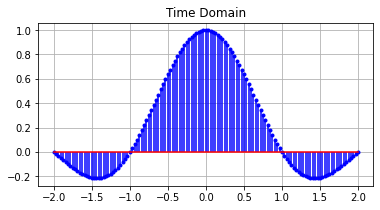

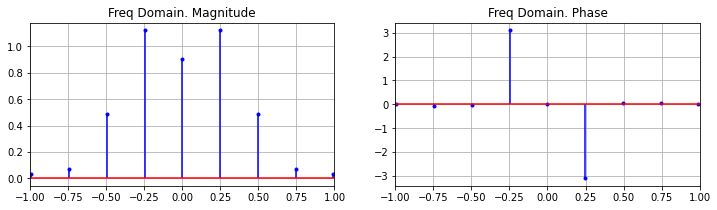

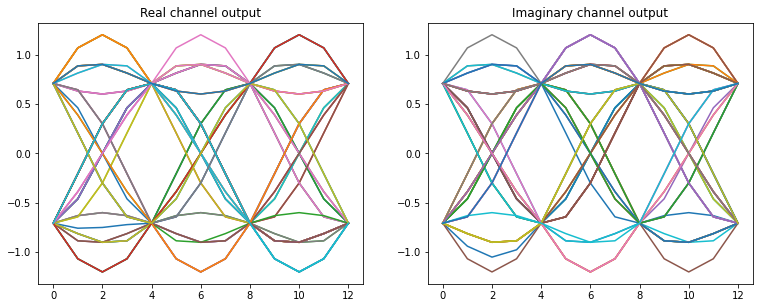

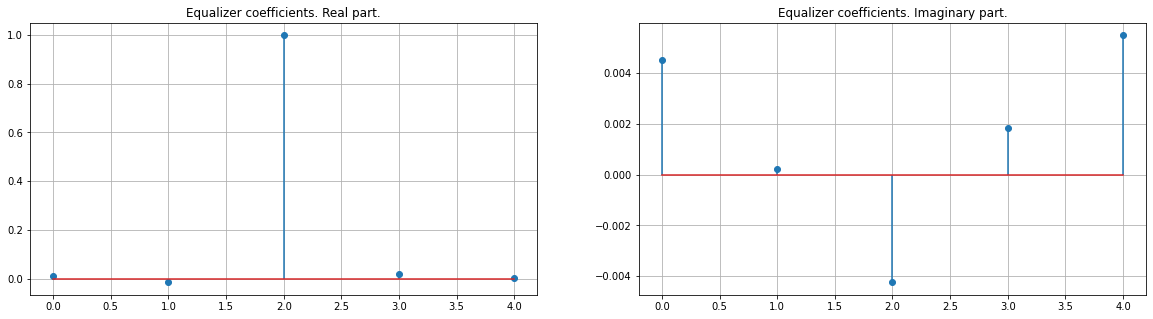

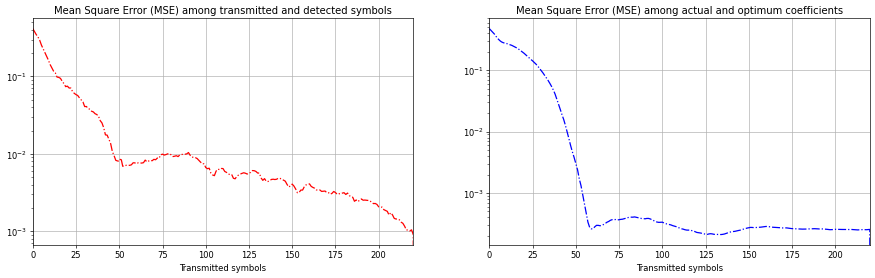

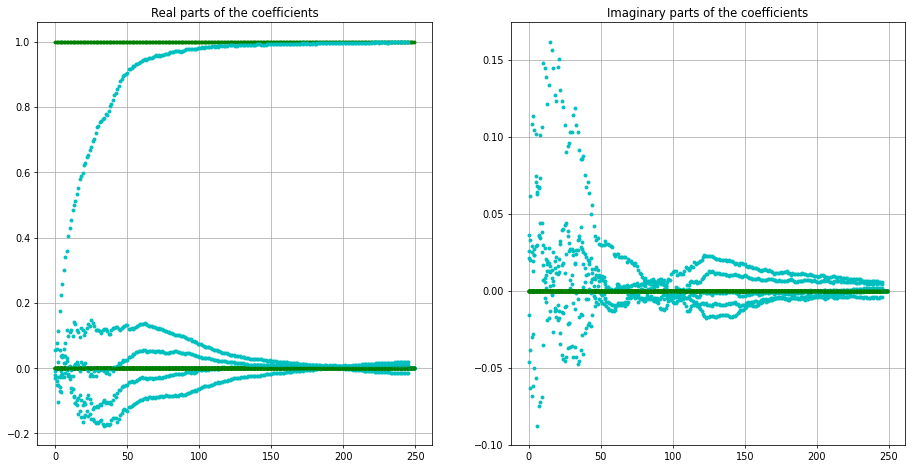

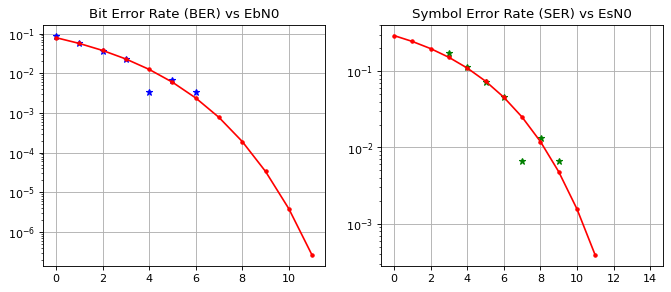

In [3]:
# Program instance.
_global_fun(alphabet = {'00':(-1-1j)/R2, '01':(-1+1j)/R2, '10':(1-1j)/R2, '11':(1+1j)/R2}, freq_shift = -0.001, phase_reversal = False, \
            phase_shift = -0.25, symbols = 250, ups_value = 4, n = 5, samplesxsym = 32, step = 0.05)
channel = rc_analysis(rolloff = 0, show_fig = [1,2,3])[0]
receive(pow_noise = 0, vct_h = channel) # ese nivel de ruido equivale al EbN0 = 14 de curva de BER          pow_noise = 0.019905358527674864
ber_ser(vct_h = channel, asymp = True, EbNodB_MAX = 12)

[0.0, 0.0]

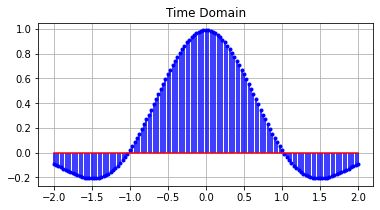

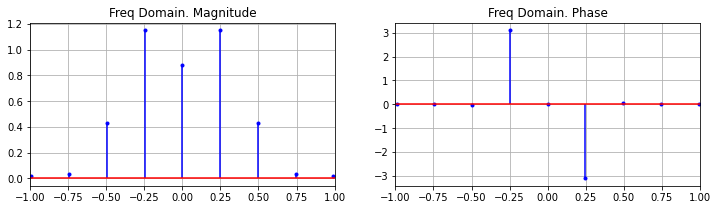

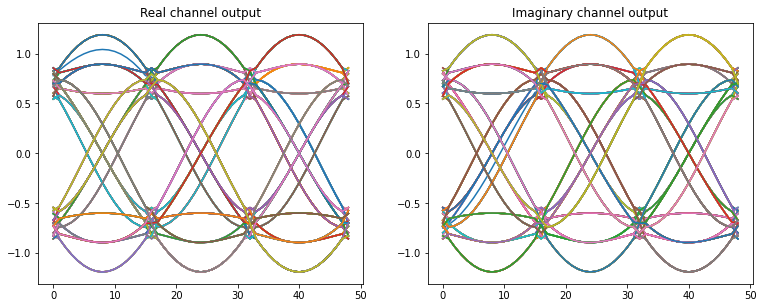

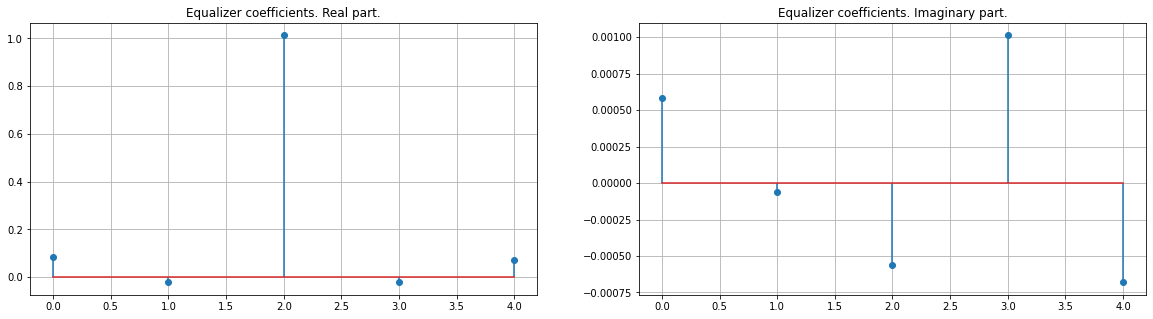

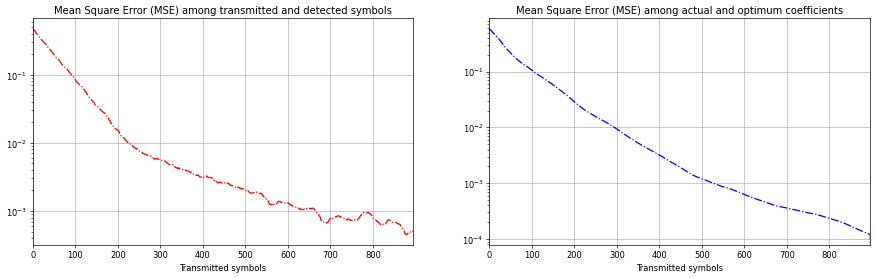

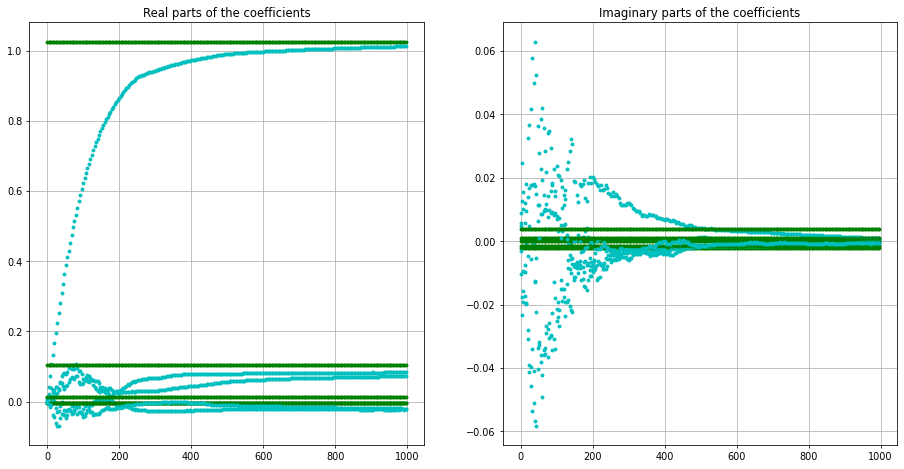

In [4]:
# Program instance.
_global_fun(alphabet = {'00':(-1-1j)/R2, '01':(-1+1j)/R2, '10':(1-1j)/R2, '11':(1+1j)/R2}, freq_shift = -0.001, phase_reversal = False, \
            phase_shift = -0.25, symbols = 1000, ups_value = 16, n = 5, samplesxsym = 32, step = 0.01)
channel = rcos_bixio(rolloff = 0.249, show_fig = [1,2,3])[0]
receive(pow_noise = 0, vct_h = channel) # ese nivel de ruido equivale al EbN0 = 14 de curva de BER           pow_noise = 0.019905358527674864
#ber_ser(vct_h = channel, asymp = True, EbNodB_MAX = 12)

Channel with more ISI

Raised cosine changing rolloff parameter

[0.0, 0.0]

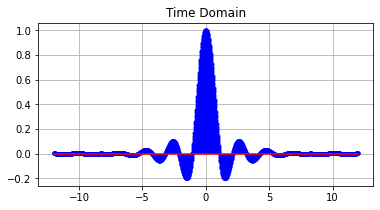

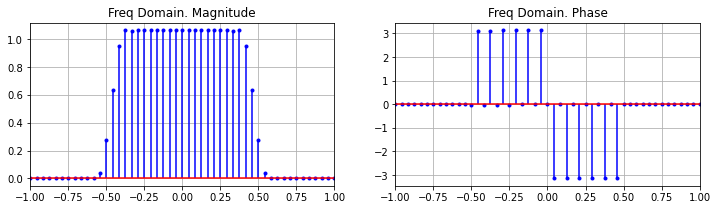

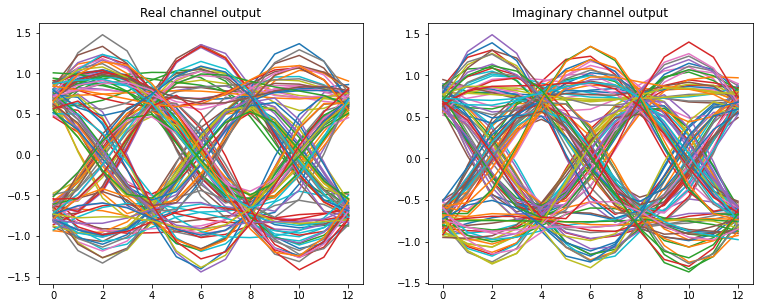

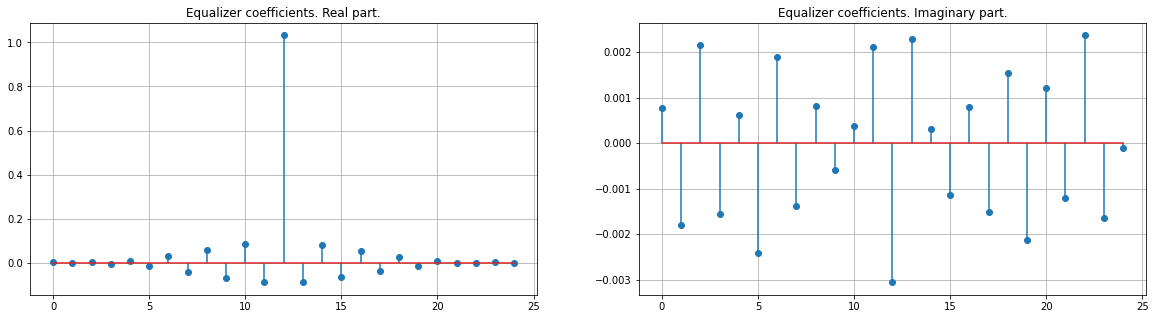

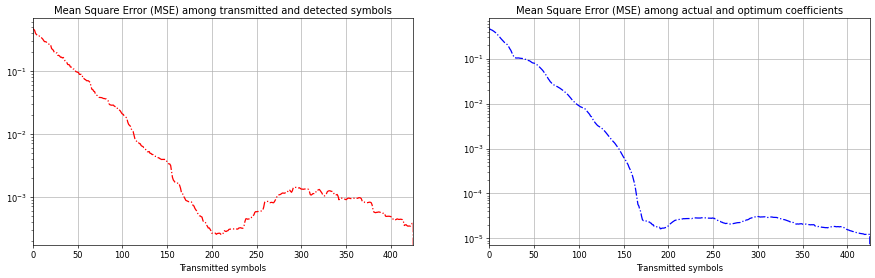

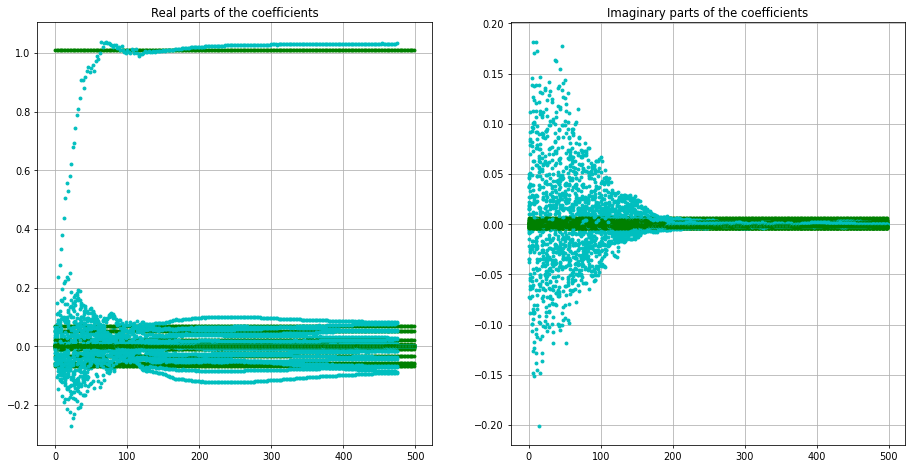

In [10]:
# Program instance. 
_global_fun(alphabet = {'00':(-1-1j)/R2, '01':(-1+1j)/R2, '10':(1-1j)/R2, '11':(1+1j)/R2}, freq_shift = -0.001, phase_reversal = False, \
            phase_shift = -0.25, symbols = 500, ups_value = 4, n = 25, samplesxsym = 64, step = 0.05)
channel = rc_analysis(W = 0.47, rolloff = 0.2, show_fig = [1,2,3])[0]
receive(pow_noise = 0, vct_h = channel) # ese nivel de ruido equivale al EbN0 = 14 de curva de BER           pow_noise = 0.019905358527674864
#ber_ser(vct_h = channel, asymp = True, EbNodB_MAX = 12) 

Channel adaptation test

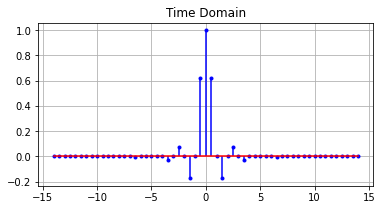

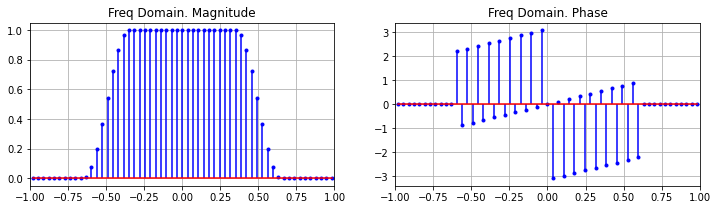

In [6]:
# delta_t = 0.5, samples_x_sym  = 2
_global_fun(alphabet = {'00':(-1-1j)/R2, '01':(-1+1j)/R2, '10':(1-1j)/R2, '11':(1+1j)/R2}, freq_shift = 0, phase_reversal = False, \
            phase_shift = 0, symbols = 500, ups_value = 4, n = 29, samplesxsym = 2, step = 0.01)
rc_analysis(delta_t = 0, W = 0.5, rolloff = 0.3, show_fig = [1,2,3], second_rc = False);

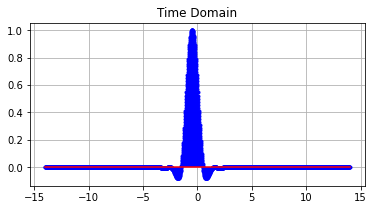

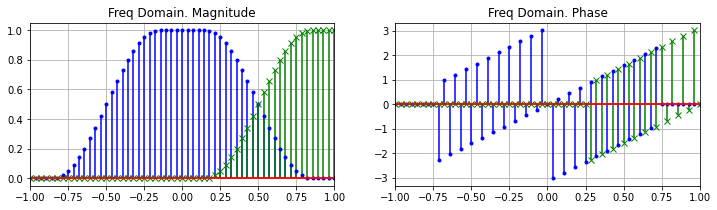

In [7]:
# delta_t = 0.5, rolloff = 0.7, samples_x_sym = 64, signal_span = 29
_global_fun(alphabet = {'00':(-1-1j)/R2, '01':(-1+1j)/R2, '10':(1-1j)/R2, '11':(1+1j)/R2}, freq_shift = 0, phase_reversal = False, \
            phase_shift = 0, symbols = 500, ups_value = 4, n = 29, samplesxsym = 64, step = 0.1)
superimposed(delta_t = 0.5, W = 0.5, rolloff = 0.7, show_fig = [1,2,3]);

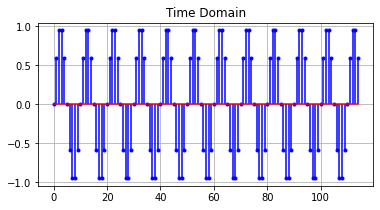

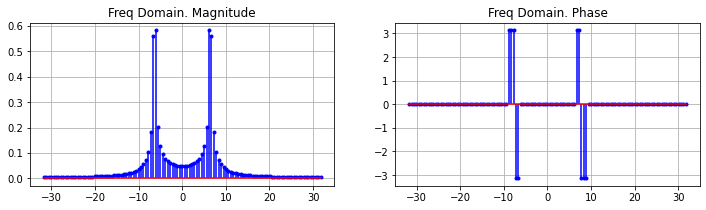

In [8]:
vct_n = np.sin(np.arange(0, 23, 0.2)*np.pi)
freq_response(vct_n = vct_n, vct_t = np.array([0]), raised_cos = False, second_rc = False, show_fig = [1, 2, 3]);

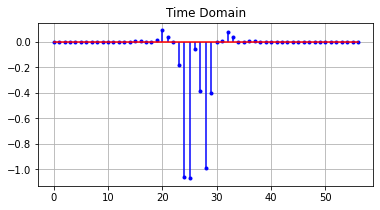

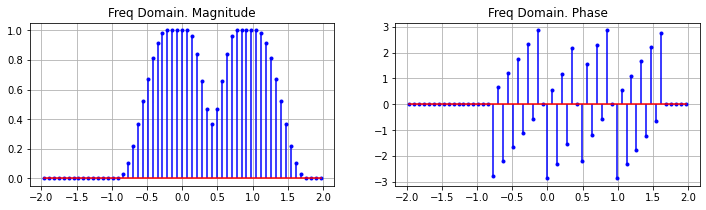

In [9]:
_global_fun(alphabet = {'00':-1-1j, '01':-1+1j, '10':1-1j, '11':1+1j}, freq_shift = 0.00, n = 15, phase_reversal = True, \
                phase_shift = 0.00, samplesxsym = 4, step = 0.001, symbols = 10000, ups_value = 1) # 999
vct_n = superimposed(delta_t = 0.5, W = 0.5, rolloff = 0.7, show_fig = [])
freq_response(vct_n, show_fig = [1, 2, 3]);

[![CC BY 4.0][cc-by-shield]][cc-by]

This work is licensed under a
[Creative Commons Attribution 4.0 International License][cc-by].

[![CC BY 4.0][cc-by-image]][cc-by]

[cc-by]: http://creativecommons.org/licenses/by/4.0/
[cc-by-image]: https://i.creativecommons.org/l/by/4.0/88x31.png
[cc-by-shield]: https://img.shields.io/badge/License-CC%20BY%204.0-lightgrey.svg

![logo_neon_erasmus](https://raw.githubusercontent.com/neon-iot/communication_labs/main/detection_theory/notebooks/images/BannerSupportErasmus_.png)